In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier

In [7]:
train = pd.read_csv("Dataset/churn-bigml-80.csv")

In [2]:
test = pd.read_csv("Dataset/churn-bigml-20.csv")

In [8]:
train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [9]:
train.columns

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

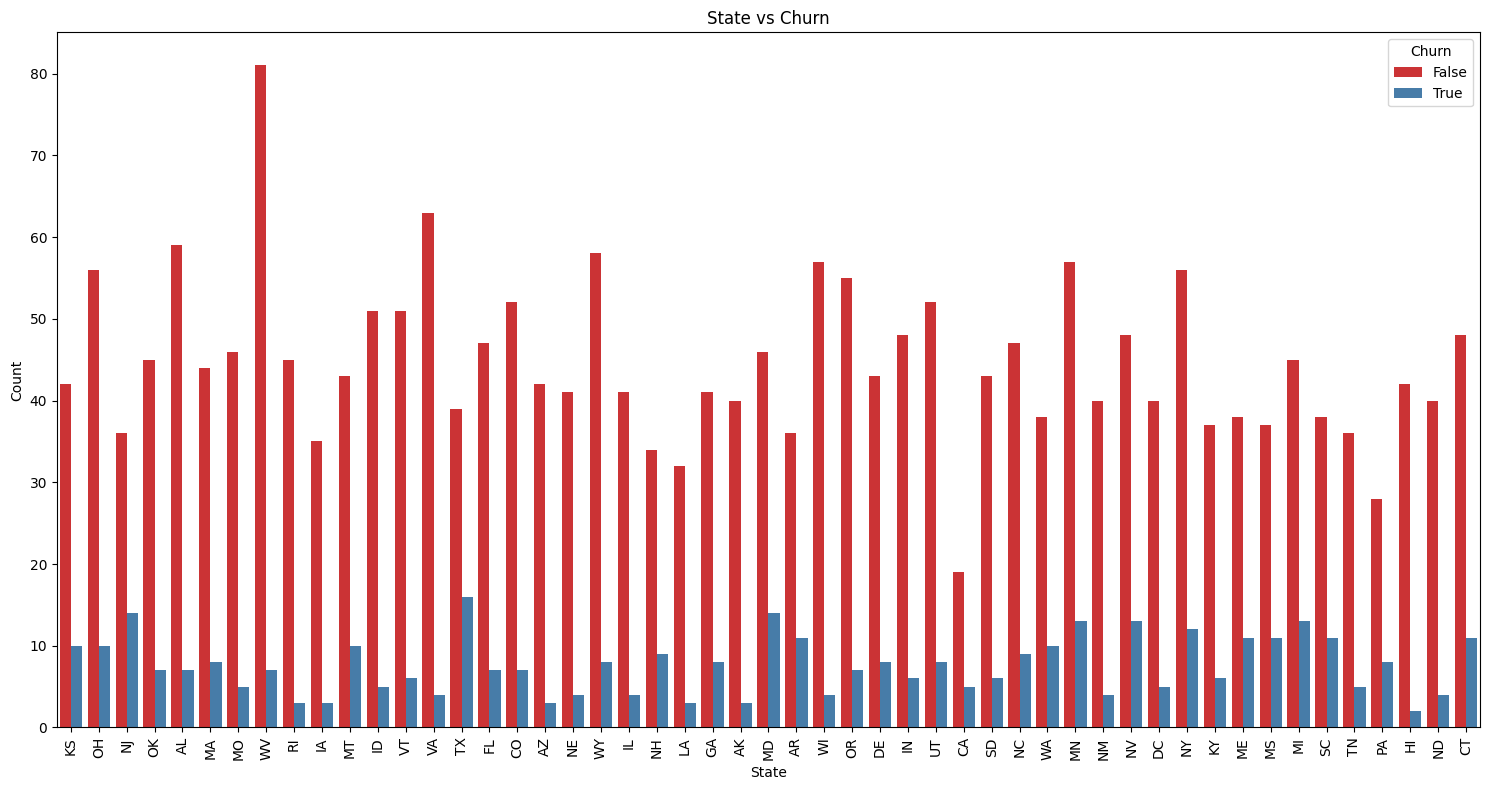

In [4]:
#bar chart state vs churn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(15, 8))
sns.countplot(x='State', hue='Churn', data=train, palette='Set1')
plt.title('State vs Churn')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Churn', loc='upper right')
plt.tight_layout()
plt.show()

In [10]:
def feature_engineering(df):
    # Convert categorical values to numeric
    df = df.replace({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})
    
    # Drop unnecessary columns
    df = df.drop(columns=['State', 'Area code'], errors='ignore')
    
    # Create new aggregated features
    df['TotalCharges'] = df['Total eve charge'] + df['Total day charge'] + df['Total intl charge'] + df['Total night charge']
    df['TotalCalls'] = df['Total eve calls'] + df['Total day calls'] + df['Total intl calls'] + df['Total night calls']
    df['Totalmins'] = df['Total eve minutes'] + df['Total day minutes'] + df['Total intl minutes'] + df['Total night minutes']
    
    # Create charge per call features
    df["day_charge_per_call"] = df["Total day charge"] / (df["Total day calls"] + 1)
    df["eve_charge_per_call"] = df["Total eve charge"] / (df["Total eve calls"] + 1)
    df["night_charge_per_call"] = df["Total night charge"] / (df["Total night calls"] + 1)
    df["intl_charge_per_call"] = df["Total intl charge"] / (df["Total intl calls"] + 1)
    
    # Create customer service interaction feature
    df["frequent_support_contacts"] = (df["Customer service calls"] > 3).astype(int)
    
    # Subscription plan interactions
    df["both_plans"] = ((df["International plan"] == 1) & (df["Voice mail plan"] == 1)).astype(int)
    df["neither_plan"] = ((df["International plan"] == 0) & (df["Voice mail plan"] == 0)).astype(int)
    
    # Call pattern ratios
    df["day_to_night_call_ratio"] = df["Total day calls"] / (df["Total night calls"] + 1)
    df["intl_call_proportion"] = df["Total intl calls"] / (df["Total day calls"] + df["Total eve calls"] + df["Total night calls"] + 1)
    
    # Usage intensity
    df["day_usage_intensity"] = df["Total day minutes"] / (df["Total day calls"] + 1)
    df["eve_usage_intensity"] = df["Total eve minutes"] / (df["Total eve calls"] + 1)
    df["night_usage_intensity"] = df["Total night minutes"] / (df["Total night calls"] + 1)
    df["intl_usage_intensity"] = df["Total intl minutes"] / (df["Total intl calls"] + 1)
    
    return df

In [11]:
train = feature_engineering(train)

C:\Users\Asus\AppData\Local\Temp\ipykernel_4492\1325507742.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})


In [12]:
test = feature_engineering(test)

C:\Users\Asus\AppData\Local\Temp\ipykernel_4492\1325507742.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})


In [6]:
train.corr()['Churn']

Account length               0.017728
International plan           0.277489
Voice mail plan             -0.099291
Number vmail messages       -0.086474
Total day minutes            0.195688
Total day calls              0.018290
Total day charge             0.195689
Total eve minutes            0.072906
Total eve calls             -0.001539
Total eve charge             0.072893
Total night minutes          0.033639
Total night calls            0.012262
Total night charge           0.033635
Total intl minutes           0.086204
Total intl calls            -0.069882
Total intl charge            0.086216
Customer service calls       0.202590
Churn                        1.000000
TotalCharges                 0.215695
TotalCalls                   0.011650
Totalmins                    0.180345
day_charge_per_call          0.147200
eve_charge_per_call          0.040950
night_charge_per_call        0.020607
intl_charge_per_call         0.117929
frequent_support_contacts    0.317615
both_plans  

In [13]:
x_train = train.drop(columns=['Churn'])
y_train = train['Churn']

x_test = test.drop(columns=['Churn'])
y_test = test['Churn']
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:16:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:16:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [10:16:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are

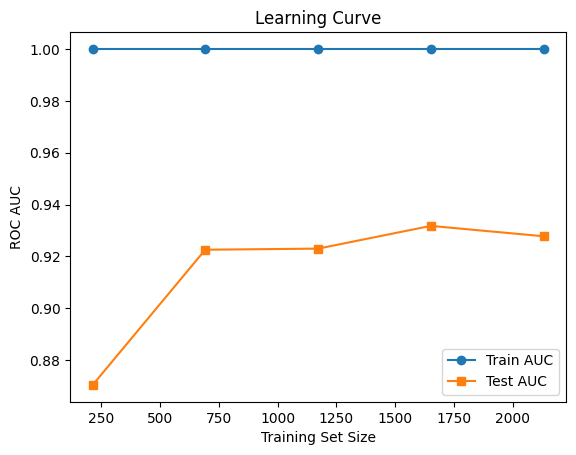

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(stacking_clf, x_train, y_train, cv=5, scoring='roc_auc')

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Train AUC', marker='o')
plt.plot(train_sizes, test_mean, label='Test AUC', marker='s')
plt.xlabel('Training Set Size')
plt.ylabel('ROC AUC')
plt.legend()
plt.title("Learning Curve")
plt.show()

In [20]:
!pip install lightgbm
!pip install catboost

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 2.8 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.8/101.7 MB 1.7 MB/s eta 0:01:01
    --------------------------------------- 1.3/101.7 MB 2.0 MB/s eta 0:00:51
    --------------------------------------- 1.6/101.7 MB 2.0 MB/s eta 0:00:49
    --------------------------------------- 2.4/101.7 MB 2.2 MB/s eta 0:00:45
   - -------------------------------------- 2.9/101.7 MB 2.4 MB/s eta 0:00:42
   - --------------------------

  You can safely remove it manually.
  You can safely remove it manually.


In [11]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
base_models = [
    ('xgb', xgb.XGBClassifier(n_estimators=100, reg_lambda = 15, subsample = 0.8, learning_rate=0.1, eval_metric='logloss', random_state=42, use_label_encoder=False)),
    ('lgbm', lgb.LGBMClassifier(n_estimators=120, reg_lambda = 15,subsample = 0.8,learning_rate=0.1, random_state=42)),
    ('cat', cb.CatBoostClassifier(n_estimators=100,reg_lambda = 15, learning_rate=0.1,subsample = 0.8, verbose=0, random_state=42))
]

# Define meta-model (Can also use XGBoost or another boosting model)
meta_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, eval_metric='logloss', random_state=42, use_label_encoder=False)

# Create Stacking Model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=10)

# Train the Stacking Model
stacking_model.fit(x_train, y_train)

# Make predictions
y_pred = stacking_model.predict_proba(x_test)[:, 1]

train_auc = roc_auc_score(y_train, stacking_model.predict_proba(x_train)[:, 1])
test_auc = roc_auc_score(y_test, stacking_model.predict_proba(x_test)[:, 1])

print(f"Stacking Train ROC AUC: {train_auc:.4f}")
print(f"Stacking Test ROC AUC: {test_auc:.4f}")


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [08:29:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\

[LightGBM] [Info] Number of positive: 388, number of negative: 2278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5632
[LightGBM] [Info] Number of data points in the train set: 2666, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145536 -> initscore=-1.770048
[LightGBM] [Info] Start training from score -1.770048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [08:29:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [08:29:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 349, number of negative: 2050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5612
[LightGBM] [Info] Number of data points in the train set: 2399, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145477 -> initscore=-1.770523
[LightGBM] [Info] Start training from score -1.770523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 349, number of negative: 2050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5615
[LightGBM] [Info] Number of data points in the train set: 2399, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145477 -> initscore=-1.770523
[LightGBM] [Info] Start training from score -1.770523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 349, number of negative: 2050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 2399, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145477 -> initscore=-1.770523
[LightGBM] [Info] Start training from score -1.770523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 349, number of negative: 2050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 2399, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145477 -> initscore=-1.770523
[LightGBM] [Info] Start training from score -1.770523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 350, number of negative: 2050
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5615
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145833 -> initscore=-1.767662
[LightGBM] [Info] Start training from score -1.767662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 349, number of negative: 2051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5616
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.145417 -> initscore=-1.771011
[LightGBM] [Info] Start training from score -1.771011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [08:29:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.1

In [12]:
import joblib

# Save the trained model
joblib.dump(stacking_model, 'stacking_model.pkl')

# Save feature engineering functions (if any)
joblib.dump(feature_engineering,'feature_engineering.pkl')

['feature_engineering.pkl']

In [14]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']